In [ ]:
import datetime
import json
import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold

# from sklearn.neighbors import KNeighborsRegressor
from typing import Dict, List, Tuple

# 自作モジュール
from dataset import MyDataset

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)  # ログのレベルを設定

In [ ]:
DARA_DIR = "./data/"
SEED = 21
RETURN_TYPE = "wfe"

In [ ]:
def cv(dataset: pd.DataFrame, strategy: str = "StratifiedKFold", n_split: int = 2) -> Tuple[float, List]:
    if strategy == "StratifiedKFold":
        kf = StratifiedKFold(n_splits=n_split, shuffle=True, random_state=SEED)
        labels = [el.month for el in dataset.index]
    else:
        kf = KFold(n_splits=n_split, shuffle=True, random_state=SEED)
        labels = None

    dataset.columns = dataset.columns.astype(str)

    """knn_scores, knn_models = [], []"""
    lgbm_scores, lgbm_models = [], []

    result = pd.DataFrame(
        columns=["Generated_kWh", "Predicted_kWh_LightGBM", "Predicted_kWh_KNN"],
        index=dataset.index,
    )

    for train_idx, val_idx in kf.split(dataset, labels):
        train, val = dataset.iloc[train_idx, :], dataset.iloc[val_idx, :]

        """
        ##
        # KNN
        ##

        knn_param = {
            "n_neighbors": 5,
            "metric": "canberra",
        }

        knn_model = KNeighborsRegressor(**knn_param)
        knn_model.fit(
            train.drop("Generated_kWh", axis=1),
            train["Generated_kWh"],
        )
        knn_models.append(knn_model)

        knn_prediction = knn_model.predict(val.drop("Generated_kWh", axis=1))

        knn_score = mean_absolute_error(val["Generated_kWh"], knn_prediction)
        knn_scores.append(knn_score)
        """

        ##
        # LightGBM
        ##

        lgbm_train = lightgbm.Dataset(
            train.drop("Generated_kWh", axis=1),
            train["Generated_kWh"],
        )
        lgbm_val = lightgbm.Dataset(
            val.drop("Generated_kWh", axis=1),
            val["Generated_kWh"],
            reference=lgbm_train,
        )
        lgbm_param = {
            "boosting": "gbdt",
            "objective": "regression",
            "metric": "mae",
            "learning_rate": 0.1,
            "verbose": -1,
        }

        lgbm_model = lightgbm.train(
            params=lgbm_param,
            train_set=lgbm_train,
            valid_sets=lgbm_val,
            num_boost_round=500,
            callbacks=[lightgbm.early_stopping(stopping_rounds=10)],
        )
        lgbm_models.append(lgbm_model)

        lgbm_prediction = lgbm_model.predict(val.drop("Generated_kWh", axis=1))

        lgbm_score = mean_absolute_error(val["Generated_kWh"], lgbm_prediction)
        lgbm_scores.append(lgbm_score)

        ##
        # 結果
        ##

        result.loc[dataset.index[val_idx], "Generated_kWh"] = val["Generated_kWh"]

        """result.loc[dataset.index[val_idx], "Predicted_kWh_KNN"] = knn_prediction"""
        result.loc[dataset.index[val_idx], "Predicted_kWh_LightGBM"] = lgbm_prediction

    """return (np.mean(knn_scores), knn_models), (np.mean(lgbm_scores), lgbm_models), result"""
    return (np.mean(lgbm_scores), lgbm_models), result

In [ ]:
def objective(trial):
    print(f"\nRunning trial number: {trial.number}")

    return_type = RETURN_TYPE

    if return_type == "hour":
        param = {}

    elif return_type == "stat":
        stats = ["mean", "std", "min", "25%", "50%", "75%", "max"]

        stat_combinations = []
        for r in range(1, len(stats) + 1):
            stat_combinations.extend(list(combinations(stats, r)))
        stat_combinations = [json.dumps(el) for el in stat_combinations if len(el) >= 4]

        param = {
            "use_stats": trial.suggest_categorical("use_stats", stat_combinations),
        }

    elif return_type == "wfe":
        n_windows = trial.suggest_float("n_windows", 0.1, 1.0)
        param = {
            "n_windows": n_windows,
            "min_window_size": trial.suggest_float("min_window_size", 0.1, n_windows),
            "random_state": SEED,
        }

    elif return_type == "bow":
        param = {
            "window_size": trial.suggest_float("window_size", 0.1, 1.0),
            "word_size": trial.suggest_float("window_size", 0.1, 1.0),
            "n_bins": trial.suggest_int("n_bins", 2, 8),
            "strategy": trial.suggest_categorical("strategy", ["uniform", "quantile", "normal"]),
            "numerosity_reduction": False,
            "window_step": trial.suggest_float("window_step", 0.1, 1.0),
            "overlapping": True,
        }

    my_dataset = MyDataset(DARA_DIR)
    dataset = my_dataset.get_dataset(return_type, **param)
    dataset = pd.concat([my_dataset.df_pv, dataset], axis=1, join="outer")
    dataset = dataset.loc[datetime.date(2022, 4, 1) : datetime.date(2023, 3, 31)]

    """(score, _), _, _ = cv(dataset)"""
    (score, _), _ = cv(dataset)

    return score

In [ ]:
study = optuna.create_study(direction="minimize")  # 最小化を指定
study.optimize(objective, n_trials=100)  # 最大試行回数を指定

# 結果の表示
best_params = study.best_params
best_value = study.best_value

print(f"最適なパラメータ: {best_params}")
print(f"最適な値: {best_value}")


Running trial number: 0
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[51]	valid_0's l1: 32.8629
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[72]	valid_0's l1: 36.7746

Running trial number: 1
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's l1: 33.4235
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[58]	valid_0's l1: 36.3163

Running trial number: 2
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 36.6691
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[79]	valid_0's l1: 39.4694

Running trial number: 3
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[39]	valid_0's l1: 36.6691
Training until validation scores don't 

In [ ]:
my_dataset = MyDataset(DARA_DIR)
dataset = my_dataset.get_dataset(return_type=RETURN_TYPE, **best_params)
dataset = pd.concat([my_dataset.df_pv, dataset], axis=1, join="outer")
dataset = dataset.loc[datetime.date(2022, 4, 1) : datetime.date(2023, 3, 31)]

(score, models), result = cv(dataset, n_split=4)
score

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[70]	valid_0's l1: 27.8283
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[43]	valid_0's l1: 31.0383
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[67]	valid_0's l1: 33.2288
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[42]	valid_0's l1: 36.7772


32.21813400176703

MAE = 32.206106951837896


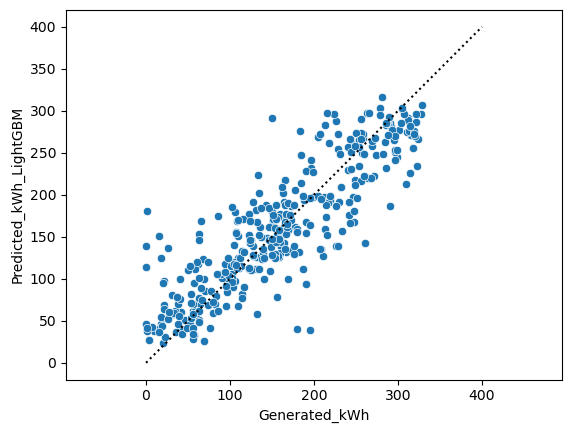

In [ ]:
print("MAE =", mean_absolute_error(result["Generated_kWh"], result["Predicted_kWh_LightGBM"]))

ax = sns.scatterplot(data=result, x="Generated_kWh", y="Predicted_kWh_LightGBM")
ax.plot([0, 400], [0, 400], linestyle=":", color="k")
plt.axis("equal")
plt.show()